In [22]:
%matplotlib inline

# Read in the data
import pandas
import numpy
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [23]:
# Read in the surveys
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [24]:
# Add DBN columns
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [25]:
# Convert columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [26]:
# Condense datasets
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [27]:
# Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

In [28]:
# Combine the datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [29]:
# Add a school district column for mapping

def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [30]:
# Find correlations
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[survey_fields].sort_values(ascending=False, na_position='last'))

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
DBN                NaN
eng_t_10           NaN
Name: sat_score, dtype: float64


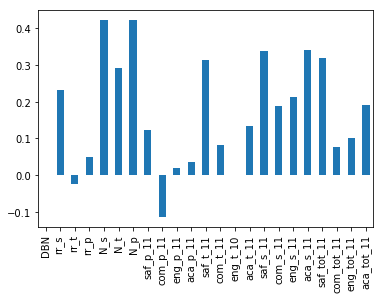

In [31]:
# Plotting survey correlations
correlations[survey_fields].plot.bar()
plt.show()

### <font color=blue>The following Survey Fields had the best coorelation to SAT scores.</font>


| Field | Abv | r value |
| :----- | :----- | :----- |
|Number of student respondents| N_s | 0.423463 |
|Number of parent respondents| N_p | 0.421530 |
|Academic expectations score based on student responses | aca_s_11 | 0.339435 |
|Safety and Respect score based on student responses | saf_s_11 | 0.337639 |
|Safety and Respect total score | saf_tot_11 | 0.318753 |
| Safety and Respect score based on teacher responses| saf_t_11 | 0.313810 |
<br>
<font color=red>Safety and respect seem to coorelate well with SAT scores.</font>
<br>
<font color=red>3 of the top 6 correlating survey fields are related to safety and respect</font>

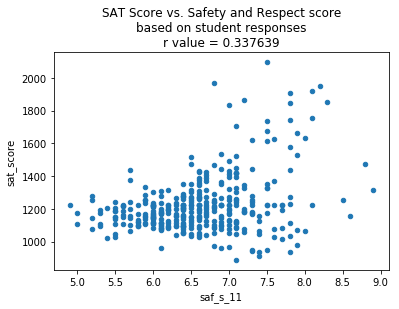

**Safety score > 7.5**

Average SAT score when the student
respondent safety score > 7.5:  1385.0

Percentage of students with an SAT score > 1400
and the safety score is > 7.5: 39.100000


**Safety score < 7.5**

Average SAT score when the student
respondent safety score < 7.5: 1200.0

Percentage of students with an SAT score > 1400
and the safety score is < 7.5: 7.600000


In [32]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.

title_text = 'SAT Score vs. Safety and Respect score\nbased on student responses\nr value = %f' % correlations['saf_s_11']
combined.plot.scatter(x='saf_s_11', y='sat_score', title=title_text)

saf_s_11_data = combined['saf_s_11']
sat_score_data = combined['sat_score']

plt.show()

mean_saf_s_11_greater_than_7_5 = sat_score_data[saf_s_11_data >= 7.5].mean()
mean_saf_s_11_greater_than_7_5 = round(mean_saf_s_11_greater_than_7_5,1)

count_saf_s_11_greater_than_7_5 = sat_score_data[combined['saf_s_11']>= 7.5].count()
count_saf_s_11_greater_than_7_5_SATabove1400 = sat_score_data[(combined['saf_s_11']>= 7.5) & (combined['sat_score'] >= 1400)].count() 
percent_saf_s_11_greater_than_7_5_SATabove1400 = count_saf_s_11_greater_than_7_5_SATabove1400 / count_saf_s_11_greater_than_7_5
percent_saf_s_11_greater_than_7_5_SATabove1400 = round(percent_saf_s_11_greater_than_7_5_SATabove1400*100,1)

print('**Safety score > 7.5**\n')
print('Average SAT score when the student\nrespondent safety score > 7.5: ', mean_saf_s_11_greater_than_7_5)
print('\nPercentage of students with an SAT score > 1400\nand the safety score is > 7.5: %f' % percent_saf_s_11_greater_than_7_5_SATabove1400)

mean_saf_s_11_less_than_7_5 = sat_score_data[saf_s_11_data < 7.5].mean()
mean_saf_s_11_less_than_7_5 = round(mean_saf_s_11_less_than_7_5,1)

count_saf_s_11_less_than_7_5 = sat_score_data[combined['saf_s_11']< 7.5].count()
count_saf_s_11_less_than_7_5_SATabove1400 = sat_score_data[(combined['saf_s_11']< 7.5) & (combined['sat_score'] >= 1400)].count() 
percent_saf_s_11_less_than_7_5_SATabove1400 = count_saf_s_11_less_than_7_5_SATabove1400 / count_saf_s_11_less_than_7_5
percent_saf_s_11_less_than_7_5_SATabove1400 = round(percent_saf_s_11_less_than_7_5_SATabove1400*100,1)

print('\n\n**Safety score < 7.5**\n')
print('Average SAT score when the student\nrespondent safety score < 7.5:', mean_saf_s_11_less_than_7_5)
print('\nPercentage of students with an SAT score > 1400\nand the safety score is < 7.5: %f' % percent_saf_s_11_less_than_7_5_SATabove1400)



## <font color=blue>Conclusion regarding safety score coorelation to SAT score.</font>
### <font color=red>The following lists correlations between safety and SAT scores</font>
<br>
-  <font color=black>The average SAT score is 185 points higher when the student based safety score is greater than 7.5</font>
-  <font color=black>39.1% of the SAT scores are 1400+ when the safety score is above 7.5</font>
-  <font color=black>7.5% of the SAT scores are 1400+ when the safety score is below 7.5</font>

/home/kkite/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/kkite/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/kkite/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


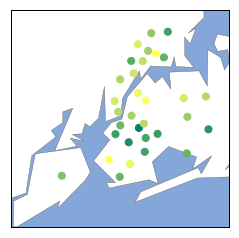

In [33]:
# Map out safety scores.
# Compute the average safety score for each district.
    
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

# Make a map that shows safety scores by district.
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you'll get an error. 
# We're working on a fix, thanks for your patience! This should work fine locally on your own computer though.
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

### <font color=red>It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.</font>

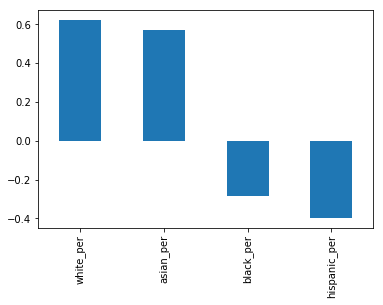

In [34]:
# Investigate racial differences in SAT scores.
    # Make a bar plot of the correlations between the columns above and sat_score.
    # Write up a Markdown cell containing your findings. Are there any unexpected correlations?

demographic_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][demographic_cols].plot.bar()
plt.show()

- <font color=blue>A higher percentage of white and asian students coorelate with higher SAT scores.  This is represented by a relatively large positive r values.</font>
- <font color=blue>A lower percentage of black and hispanic students coorelate with higher SAT scores.  This is represented by a relatively large negative r values.</font>

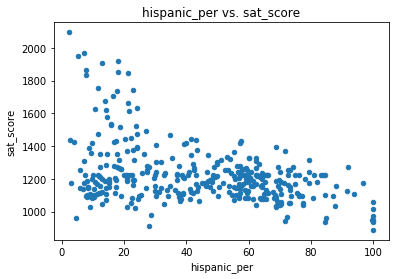

In [35]:
# Explore schools with low SAT scores and high values for hispanic_per.
    # Make a scatter plot of hispanic_per vs. sat_score.
    # What does the scatter plot show? Record any interesting observsations in a Markdown cell.
combined.plot.scatter(x='hispanic_per', y='sat_score', title='hispanic_per vs. sat_score')

### <font color=black>This plots shows that schools that have greater than ~ 25% hispanic have a drastically reduced SAT scores.</font>

In [36]:
# Research any schools with a hispanic_per greater than 95%.
    # Find the school names in the data.
    # Use Wikipedia and Google to research the schools by name.
    # Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

school_names_95perPlus_hispanic = combined['SCHOOL NAME'][combined['hispanic_per'] > 95.0]
school_names_95perPlus_hispanic_SAT_mean = combined['sat_score'][combined['hispanic_per'] > 95.0].mean()
print(school_names_95perPlus_hispanic)
print('\nThe mean SAT score is', school_names_95perPlus_hispanic_SAT_mean)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The mean SAT score is 992.375


### <font color=black>The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.</font>

In [37]:
# Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
    # Find the school names in the data.
    # Use Wikipedia and Google to research the schools by name.
    # Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
    
school_names_10perMinus_hispanic = combined['SCHOOL NAME'][(combined['hispanic_per'] < 10.0) & (combined['sat_score'] > 1800)]
school_names_10perMinus_hispanic_SAT_mean = combined['sat_score'][(combined['hispanic_per'] < 10.0) & (combined['sat_score'] > 1800)].mean()
print(school_names_10perMinus_hispanic)
print('\nThe mean SAT score is', school_names_10perMinus_hispanic_SAT_mean)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The mean SAT score is 1943.8


### <font color=black>Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.</font>

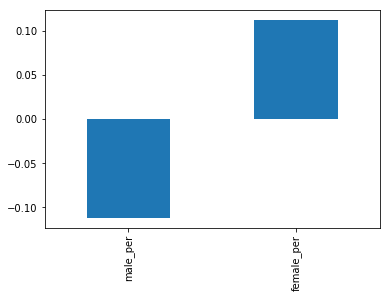

In [38]:
# Investigate gender differences in SAT scores.
    # Make a bar plot of the correlations between the columns above and sat_score.
    # Record your findings in a Markdown cell. Are there any unexpected correlations?
    
gender_cols = ['male_per', 'female_per']
combined.corr()["sat_score"][gender_cols].plot.bar()
plt.show()

### <font color=black>There is a small correlation showing that schools with a greater % of girls do better on SAT scores.  Alternatively, there is a similar magnitude of coorleation showing that schools with a smaller % of boys do better on SAT scores.</font>

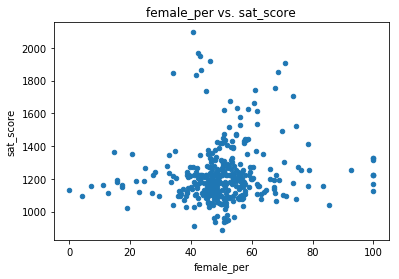

In [39]:
# Investigate schools with high SAT scores and a high female_per.
    # Make a scatter plot of female_per vs. sat_score.
    # What does the scatter plot show? Record any interesting observations in a Markdown cell.
    
combined.plot.scatter(x='female_per', y='sat_score', title='female_per vs. sat_score')
plt.show()

### <font color=black>Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.</font>

In [40]:
# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
    # Find the school names in the data.
    # Use Wikipedia and Google to research the schools by name.
    # Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
    
print(combined['SCHOOL NAME'][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## <font color=black>These schools appears to be very selective liberal arts schools that have high academic standards.</font>

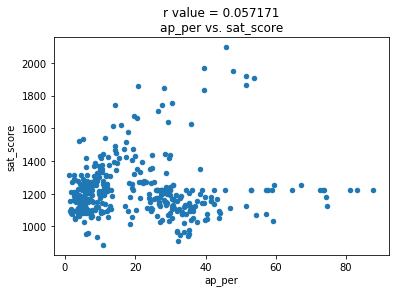

In [43]:
# Calculate the percentage of students in each school that took an AP exam.
    # Divide the AP Test Takers column by the total_enrollment column.
    # The column name AP Test Takers has a space at the end -- don't forget to add it!
    # Assign the result to the ap_per column.

combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100

# Investigate the relationship between AP scores and SAT scores.
    # Make a scatter plot of ap_per vs. sat_score.
    # What does the scatter plot show? Record any interesting observations in a Markdown cell.

r_value = combined.corr()['sat_score']['ap_per']
t = 'r value = %f\nap_per vs. sat_score' % r_value
combined.plot.scatter(x='ap_per', y='sat_score', title=t)


### <font color =black>There is a very weak coorelation between the percentage of students taking AP exams and SAT scores</font>